 ФИО: Усцов Артем Алексеевич

In [ ]:
# uncomment to install pmdarima, plotly for the first
!pip install pmdarima
!pip install plotly

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import os
from tqdm import *
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import pmdarima as pm
import numpy as np
%matplotlib inline

# Ноутбук для ДЗ №8 обработка временных последовательностей RNN
В данном дз вам будут данных времменая последовательно, которая описывает распределение хитов по времени за несколько лет. Вам нужно будет обучить модель RNN на исторических данных и потом сделать предсказание для "будущего" года, в текущей задаче это 2019 год

## Готовим данные
Три файла с данными
1. исторические данные - train
2. Тестовые данные текущего момента - derived
3. Пример сабмита резкльтатов конкурса на кагле

In [ ]:
# get data
!wget https://github.com/Totenkaf/DL_Homeworks/raw/main/HW_8/data/derived.csv -P data/
!wget https://github.com/Totenkaf/DL_Homeworks/raw/main/HW_8/data/sample_submission.csv -P data/
!wget https://github.com/Totenkaf/DL_Homeworks/raw/main/HW_8/data/train.csv -P data/

--2022-12-23 13:46:34--  https://github.com/Totenkaf/DL_Homeworks/raw/main/HW_8/data/derived.csv
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Totenkaf/DL_Homeworks/main/HW_8/data/derived.csv [following]
--2022-12-23 13:46:34--  https://raw.githubusercontent.com/Totenkaf/DL_Homeworks/main/HW_8/data/derived.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7675 (7.5K) [text/plain]
Saving to: ‘data/derived.csv’

derived.csv         100%[===================>]   7.50K  --.-KB/s    in 0s      

2022-12-23 13:46:35 (50.9 MB/s) - ‘data/derived.csv’ saved [7675/7675]

--2022-12-23 13:46:35--  https:

In [ ]:
def read_set(file):
    data = pd.read_csv(file)
    data['date'] = pd.to_datetime(data['date'])
    data = data.rename(columns = {'DATE':'date'})
    data = data.rename(columns = {'hits':'value'})
    data = data.set_index('date')
    return data

In [ ]:
data = pd.read_csv('data/train.csv')
data

,date,hits
0,2016-01-01,201979088
1,2016-01-02,223095158
2,2016-01-03,233791442
3,2016-01-04,259684220
4,2016-01-05,267112490
...,...,...
1091,2018-12-27,241134980
1092,2018-12-28,234865040
1093,2018-12-29,195884690
1094,2018-12-30,125587958


In [ ]:
data_train = read_set('data/train.csv')
data_test =  read_set('data/derived.csv')
data_sample = read_set('data/sample_submission.csv')

In [ ]:
data_train

,value
date,
2016-01-01,201979088
2016-01-02,223095158
2016-01-03,233791442
2016-01-04,259684220
2016-01-05,267112490
...,...
2018-12-27,241134980
2018-12-28,234865040
2018-12-29,195884690


### Проверим наши данные, что мы загрузили

In [ ]:
print( data_train.info() )
print( data_test.info() )
print( data_sample.info() )

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1096 entries, 2016-01-01 to 2018-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   1096 non-null   int64
dtypes: int64(1)
memory usage: 17.1 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2019-01-01 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   365 non-null    int64
dtypes: int64(1)
memory usage: 5.7 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2019-01-01 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   365 non-null    int64
dtypes: int64(1)
memory usage: 5.7 KB
None


In [ ]:
data_train.describe()

,value
count,1.096000e+03
mean,2.792255e+08
std,7.677884e+07
min,1.103556e+08
25%,2.317301e+08
50%,2.791131e+08
75%,3.287730e+08
max,4.550733e+08


In [ ]:
data_test.describe()

,value
count,3.650000e+02
mean,2.250691e+08
std,6.798229e+07
min,1.055197e+08
25%,1.467913e+08
50%,2.525773e+08
75%,2.724223e+08
max,3.410300e+08


In [ ]:
data_sample.describe()

,value
count,365.0
mean,110355560.0
std,0.0
min,110355560.0
25%,110355560.0
50%,110355560.0
75%,110355560.0
max,110355560.0


## Графики наших временных последовательностей

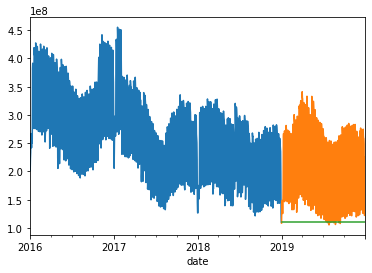

In [ ]:
plt.figure()
data_train['value'].plot(kind = 'line')
data_test['value'].plot(kind = 'line')
data_sample['value'].plot(kind = 'line')
plt.show()

## Статистическая модель [ARIMA](https://ru.wikipedia.org/wiki/ARIMA)


In [ ]:
# обучаем модель
arima_model=model = pm.auto_arima(data_train, seasonal = True,m = 4,test='adf',error_action='ignore',  
                           suppress_warnings=True,
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=42026.193, Time=4.04 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=42912.228, Time=0.10 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=42352.663, Time=1.98 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=42271.764, Time=1.01 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=45821.113, Time=0.11 sec
 ARIMA(2,0,2)(0,0,1)[4] intercept   : AIC=42138.118, Time=2.40 sec
 ARIMA(2,0,2)(1,0,0)[4] intercept   : AIC=42130.455, Time=5.53 sec
 ARIMA(2,0,2)(2,0,1)[4] intercept   : AIC=41842.461, Time=9.60 sec
 ARIMA(2,0,2)(2,0,0)[4] intercept   : AIC=42088.126, Time=5.71 sec
 ARIMA(2,0,2)(2,0,2)[4] intercept   : AIC=41829.133, Time=6.25 sec
 ARIMA(2,0,2)(1,0,2)[4] intercept   : AIC=42095.534, Time=6.06 sec
 ARIMA(1,0,2)(2,0,2)[4] intercept   : AIC=42117.810, Time=4.45 sec
 ARIMA(2,0,1)(2,0,2)[4] intercept   : AIC=42107.831, Time=3.64 sec
 ARIMA(3,0,2)(2,0,2)[4] intercept   : AIC=41841.306, Time=8.03 sec
 ARIMA(2,0,3)(2,0,2

In [ ]:
prediction = pd.DataFrame(model.predict(n_periods = int(data_test.size)), data_test.index)

In [ ]:
prediction

,0
date,
2019-01-01,2.229735e+08
2019-01-02,2.775709e+08
2019-01-03,2.357891e+08
2019-01-04,1.699423e+08
2019-01-05,2.176884e+08
...,...
2019-12-27,2.778545e+08
2019-12-28,2.758577e+08
2019-12-29,2.743928e+08


In [ ]:
prediction = prediction .rename(columns = {0:'value'})

смотрим, что она нам предсказала

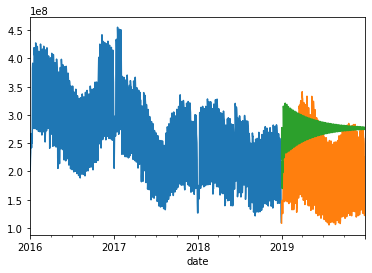

In [ ]:
plt.figure()
data_train['value'].plot(kind = 'line')
data_test['value'].plot(kind = 'line')
#plt.plot(data_forecaste, label = "Prediction")
prediction['value'].plot(kind = 'line')
plt.show()

### Функция подсчета метрик для конкурса

In [ ]:
def MAPE(y_true, y_pred):
    mape = np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), 1e-6)
    mape  = np.average(mape) * 100
    return mape

### MAPE для ARIMA и тестового сабмишена

In [ ]:
MAPE(data_test, prediction)

39.554010858427134

In [ ]:
MAPE(data_test, data_sample)

44.81735178659308

## Из пандас строим датасет

In [ ]:
class Stats:
    def __init__(self, dataset):
        self.mean = np.mean(dataset)
        self.std = np.std(dataset)
        self.data = (dataset - self.mean) / self.std 

stats = Stats(data_train)

In [ ]:
class TSDataset(Dataset):
    
    def __init__(self, data, seq_len):
        super().__init__()
        self._len = len(data) - seq_len + 1 # Кол-во проходов заданным окном
        self.mean = stats.mean 
        self.std = stats.std
        self.data = (data- self.mean) / self.std # Нормализация
        self.seq_len = seq_len # Длина окна
        
    def __len__(self):
        return self._len
    
    def __getitem__(self, idx):
        d = self.data[idx:idx + self.seq_len] # Берем последовательность датафрейма
        targets = []
        days   = []
        months = []
        year = []
        weekday = []
        for row in  d.iterrows(): # итератор по строкам dataframe
            targets += [ row[1]['value'] ] # Получить value из строки
            days += [ row[0].day ] # 
            months += [row[0].month]
            year += [row[0].year]
            weekday += [row[0].weekday()]
            
        return torch.LongTensor(days), \
               torch.LongTensor(months), \
               torch.LongTensor(weekday), \
               torch.FloatTensor(targets)

In [ ]:
ds_train = TSDataset(data_train, 20) 
ds_test  = TSDataset(data_test, 20)
print(len(ds_train))


1077


## Теперь нужно определить нашу модель 

In [ ]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(777)

In [ ]:
import datetime
ans = datetime.date(2022, 1, 4)
ans.weekday()

1

In [ ]:
class TimeSeriesModel(nn.Module):
    def __init__(self, hidden_size: int, input_sizes: tuple):
        super().__init__()
        self.mon_emb = nn.Embedding(12+1, input_sizes[0]) # Эмбеддинги для месяцев (обучаемые)
        self.day_emb = nn.Embedding(31+1, input_sizes[1]) # Эмбеддинги для годов (обучаемые)
        self.weekday_emb = nn.Embedding(7, input_sizes[2])
        self.weekend_emb = nn.Embedding(7, input_sizes[3])
        
        # LSTM input: Эмбеддинги годов, месяцев, значение                      
        self._rnn = nn.LSTM(input_sizes[0] + input_sizes[1] + input_sizes[2] + input_sizes[3] + 1,
                            hidden_size,  batch_first=True, dropout=0.3)
        self._output = nn.Linear(hidden_size, 1)

    def forward(self, batch, ctx = None):
        days, mons, weekday, targets = batch
        mon_tensor = self.mon_emb(mons) # batch_sz x seq_len x emb_len (8 x 20 x 4)
        day_tensor = self.day_emb(days)
        weekday_tensor = self.weekday_emb(weekday)
        weekend = ((weekday == 5) | (weekday == 6))
        weekend_tensor = self.weekend_emb(weekend.long())
        rnn_input  = torch.cat([mon_tensor, day_tensor, weekday_tensor, weekend_tensor], dim=-1) # 8 x 20 x 8
        targets = targets.unsqueeze(-1)
        rnn_input = torch.cat([rnn_input, targets ], dim=-1) # 8 x 20 x 9
        # Берем все элементы последовательности, кроме последнего, предсказание идет на 1 шаг вперед
        rnn_input = rnn_input[:, :-1, :] if ctx is None else rnn_input # 8 x 19 x 9
        output, ctx = self._rnn(rnn_input, ctx)
        # 8 x 19 x 32, 1 x 8 x 32
        # print((self._output(output)).size()) 8 x 19 x 1
        output = self._output(output).squeeze() # 8 x 19 
        return output, ctx        

### Определяем даталоадеры для теста и трейна

In [ ]:
batch_sz = 8
hidden_size = 32
emb_size = (3, 4, 2, 1)

dl_train = DataLoader(ds_train, batch_sz , True)
dl_test = DataLoader(ds_test, batch_sz , False)
series_model = TimeSeriesModel(hidden_size, emb_size)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
from torch.optim.lr_scheduler import ExponentialLR

In [ ]:
loss = nn.L1Loss()
optimizer = Adam(series_model.parameters(), lr=7e-4)# lr=5e-4)
scheduler = ExponentialLR(optimizer, gamma=0.97)

In [ ]:
# инициализируем тензорборд, для вывода графиков
writer = SummaryWriter(log_dir='./rnn_hw')

### Обучаем модель

In [ ]:
global_epoch = 0
global_iter = 0

In [ ]:
def test_model(epoch):
    test_iter  = tqdm(dl_test)
    sum_loss = 0
    num_batches = 0
    for i, batch in enumerate(test_iter):
        # Чтобы сохранялась временная зависимость
        # для предсказания таргет должен быть смешен на один временной шаг
        # относительно входа модели
        target = batch[-1][:, 1:]
        result, _ = series_model(batch)
        batch_loss = loss(result, target)
        sum_loss += batch_loss
        num_batches += 1
    sum_loss /= num_batches
    writer.add_scalar('Loss/val', sum_loss , epoch)
    print("Test:", sum_loss.item(), epoch)
    return sum_loss

In [ ]:
# модель обучаем в режиме teacher forcing, т.е. на вход подаем сразу всю последовательность,
# на выходе таргет должен быть смещен на один временной шаг, чтобы правильно считался лосс

for epoch in range(0, 500):
    epoch_iter = tqdm(dl_train)
    series_model.train()
    for batch in epoch_iter:
        optimizer.zero_grad()
        # Чтобы сохранялась временная зависимость
        # для предсказания таргет должен быть смешен на один временной шаг
        # относительно входа модели
        #print(batch[0].size())
        # batch.size() : 4 (day, month, year, target) x batch_sz x seg_len
        #import sys
        #sys.exit()
        target = batch[-1][:,1:] # Берем все значения, начиная  с 1
        result, hidden = series_model(batch)
        batch_loss = loss(result, target)
        batch_loss.backward()
        epoch_iter.set_description("Epoch: %04d, Iter Loss: %.4f"  %(epoch, batch_loss))
        writer.add_scalar('Loss/train', batch_loss , global_iter)
        global_iter += 1
        optimizer.step()
    scheduler.step()
    with torch.no_grad():
        series_model.eval()
        test_model(global_epoch)
    global_epoch += 1

100%|██████████| 44/44 [00:00<00:00, 86.05it/s]


Test: 0.6834279894828796 0


100%|██████████| 44/44 [00:00<00:00, 88.89it/s]


Test: 0.37465858459472656 1


100%|██████████| 44/44 [00:00<00:00, 90.73it/s]


Test: 0.2615906894207001 2


100%|██████████| 44/44 [00:00<00:00, 79.12it/s]


Test: 0.23638056218624115 3


100%|██████████| 44/44 [00:00<00:00, 87.98it/s]


Test: 0.21951276063919067 4


100%|██████████| 44/44 [00:00<00:00, 88.44it/s]


Test: 0.21199393272399902 5


100%|██████████| 44/44 [00:00<00:00, 86.60it/s]


Test: 0.2025613933801651 6


100%|██████████| 44/44 [00:00<00:00, 84.75it/s]


Test: 0.20096993446350098 7


100%|██████████| 44/44 [00:00<00:00, 86.89it/s]


Test: 0.19684743881225586 8


100%|██████████| 44/44 [00:00<00:00, 94.27it/s]


Test: 0.19505806267261505 9


100%|██████████| 44/44 [00:00<00:00, 86.91it/s]


Test: 0.1867738664150238 10


100%|██████████| 44/44 [00:00<00:00, 89.91it/s]


Test: 0.18728986382484436 11


100%|██████████| 44/44 [00:00<00:00, 91.13it/s]


Test: 0.18643182516098022 12


100%|██████████| 44/44 [00:00<00:00, 90.27it/s]


Test: 0.18144024908542633 13


100%|██████████| 44/44 [00:00<00:00, 89.18it/s]


Test: 0.18530155718326569 14


100%|██████████| 44/44 [00:00<00:00, 91.70it/s]


Test: 0.18008269369602203 15


100%|██████████| 44/44 [00:00<00:00, 91.52it/s]


Test: 0.18534941971302032 16


100%|██████████| 44/44 [00:00<00:00, 89.67it/s]


Test: 0.17895494401454926 17


100%|██████████| 44/44 [00:00<00:00, 90.62it/s]


Test: 0.17925027012825012 18


100%|██████████| 44/44 [00:00<00:00, 89.40it/s]


Test: 0.1825268715620041 19


100%|██████████| 44/44 [00:00<00:00, 89.62it/s]


Test: 0.18128377199172974 20


100%|██████████| 44/44 [00:00<00:00, 85.16it/s]


Test: 0.17948029935359955 21


100%|██████████| 44/44 [00:00<00:00, 87.70it/s]


Test: 0.18151497840881348 22


100%|██████████| 44/44 [00:00<00:00, 89.65it/s]


Test: 0.1770850569009781 23


100%|██████████| 44/44 [00:00<00:00, 85.44it/s]


Test: 0.181742325425148 24


100%|██████████| 44/44 [00:00<00:00, 89.75it/s]


Test: 0.17933492362499237 25


100%|██████████| 44/44 [00:00<00:00, 86.89it/s]


Test: 0.1792488694190979 26


100%|██████████| 44/44 [00:00<00:00, 89.80it/s]


Test: 0.1790822297334671 27


100%|██████████| 44/44 [00:00<00:00, 87.20it/s]


Test: 0.17774781584739685 28


100%|██████████| 44/44 [00:00<00:00, 91.38it/s]


Test: 0.17784012854099274 29


100%|██████████| 44/44 [00:00<00:00, 89.00it/s]


Test: 0.17786769568920135 30


100%|██████████| 44/44 [00:00<00:00, 90.71it/s]


Test: 0.18048687279224396 31


100%|██████████| 44/44 [00:00<00:00, 88.43it/s]


Test: 0.17803806066513062 32


100%|██████████| 44/44 [00:00<00:00, 87.66it/s]


Test: 0.17845597863197327 33


100%|██████████| 44/44 [00:00<00:00, 86.39it/s]


Test: 0.17614279687404633 34


100%|██████████| 44/44 [00:00<00:00, 90.20it/s]


Test: 0.1775769144296646 35


100%|██████████| 44/44 [00:00<00:00, 85.66it/s]


Test: 0.17926684021949768 36


100%|██████████| 44/44 [00:00<00:00, 56.63it/s]


Test: 0.17761705815792084 37


100%|██████████| 44/44 [00:00<00:00, 91.54it/s]


Test: 0.17576491832733154 38


100%|██████████| 44/44 [00:00<00:00, 87.56it/s]


Test: 0.17692133784294128 39


100%|██████████| 44/44 [00:00<00:00, 86.37it/s]


Test: 0.17769600450992584 40


100%|██████████| 44/44 [00:00<00:00, 82.02it/s]


Test: 0.1766853779554367 41


100%|██████████| 44/44 [00:00<00:00, 87.20it/s]


Test: 0.17701126635074615 42


100%|██████████| 44/44 [00:00<00:00, 86.43it/s]


Test: 0.1766195148229599 43


100%|██████████| 44/44 [00:00<00:00, 85.85it/s]


Test: 0.17768318951129913 44


100%|██████████| 44/44 [00:00<00:00, 87.20it/s]


Test: 0.17708784341812134 45


100%|██████████| 44/44 [00:00<00:00, 91.84it/s]


Test: 0.17623403668403625 46


100%|██████████| 44/44 [00:00<00:00, 93.28it/s]


Test: 0.17541375756263733 47


100%|██████████| 44/44 [00:00<00:00, 79.88it/s]


Test: 0.176765576004982 48


100%|██████████| 44/44 [00:00<00:00, 90.62it/s]


Test: 0.17640714347362518 49


100%|██████████| 44/44 [00:00<00:00, 92.51it/s]


Test: 0.17649079859256744 50


100%|██████████| 44/44 [00:00<00:00, 88.64it/s]


Test: 0.17631076276302338 51


100%|██████████| 44/44 [00:00<00:00, 90.36it/s]


Test: 0.17624421417713165 52


100%|██████████| 44/44 [00:00<00:00, 93.69it/s]


Test: 0.17673133313655853 53


100%|██████████| 44/44 [00:00<00:00, 82.48it/s]


Test: 0.17761392891407013 54


100%|██████████| 44/44 [00:00<00:00, 85.56it/s]


Test: 0.17663104832172394 55


100%|██████████| 44/44 [00:00<00:00, 81.52it/s]


Test: 0.1764129400253296 56


100%|██████████| 44/44 [00:00<00:00, 85.77it/s]


Test: 0.17716680467128754 57


100%|██████████| 44/44 [00:00<00:00, 91.94it/s]


Test: 0.17647875845432281 58


100%|██████████| 44/44 [00:00<00:00, 90.86it/s]


Test: 0.1759127527475357 59


100%|██████████| 44/44 [00:00<00:00, 86.17it/s]


Test: 0.1767926812171936 60


100%|██████████| 44/44 [00:00<00:00, 83.16it/s]


Test: 0.17637230455875397 61


100%|██████████| 44/44 [00:00<00:00, 91.23it/s]


Test: 0.1764814704656601 62


100%|██████████| 44/44 [00:00<00:00, 90.45it/s]


Test: 0.17621532082557678 63


100%|██████████| 44/44 [00:00<00:00, 78.58it/s]


Test: 0.17722684144973755 64


100%|██████████| 44/44 [00:00<00:00, 92.01it/s]


Test: 0.17611263692378998 65


100%|██████████| 44/44 [00:00<00:00, 89.04it/s]


Test: 0.17690683901309967 66


100%|██████████| 44/44 [00:00<00:00, 86.37it/s]


Test: 0.17712832987308502 67


100%|██████████| 44/44 [00:00<00:00, 83.99it/s]


Test: 0.17620089650154114 68


100%|██████████| 44/44 [00:00<00:00, 84.12it/s]


Test: 0.17679443955421448 69


100%|██████████| 44/44 [00:00<00:00, 86.59it/s]


Test: 0.17621463537216187 70


100%|██████████| 44/44 [00:00<00:00, 90.13it/s]


Test: 0.17701929807662964 71


100%|██████████| 44/44 [00:00<00:00, 93.56it/s]


Test: 0.17662972211837769 72


100%|██████████| 44/44 [00:00<00:00, 89.45it/s]


Test: 0.17611604928970337 73


100%|██████████| 44/44 [00:00<00:00, 91.58it/s]


Test: 0.1764630526304245 74


100%|██████████| 44/44 [00:00<00:00, 88.60it/s]


Test: 0.17711259424686432 75


100%|██████████| 44/44 [00:00<00:00, 87.53it/s]


Test: 0.17615783214569092 76


100%|██████████| 44/44 [00:00<00:00, 86.25it/s]


Test: 0.17686885595321655 77


100%|██████████| 44/44 [00:00<00:00, 88.73it/s]


Test: 0.1763785481452942 78


100%|██████████| 44/44 [00:00<00:00, 75.97it/s]


Test: 0.1759907603263855 79


100%|██████████| 44/44 [00:00<00:00, 81.44it/s]


Test: 0.17732731997966766 80


100%|██████████| 44/44 [00:00<00:00, 90.66it/s]


Test: 0.17666536569595337 81


100%|██████████| 44/44 [00:00<00:00, 86.90it/s]


Test: 0.17637047171592712 82


100%|██████████| 44/44 [00:00<00:00, 88.64it/s]


Test: 0.1759667992591858 83


100%|██████████| 44/44 [00:00<00:00, 92.35it/s]


Test: 0.1758565902709961 84


100%|██████████| 44/44 [00:00<00:00, 87.15it/s]


Test: 0.1765989065170288 85


100%|██████████| 44/44 [00:00<00:00, 87.46it/s]


Test: 0.1767207533121109 86


100%|██████████| 44/44 [00:00<00:00, 88.00it/s]


Test: 0.17652763426303864 87


100%|██████████| 44/44 [00:00<00:00, 91.44it/s]


Test: 0.1767890602350235 88


100%|██████████| 44/44 [00:00<00:00, 87.78it/s]


Test: 0.17647261917591095 89


100%|██████████| 44/44 [00:00<00:00, 86.65it/s]


Test: 0.17631791532039642 90


100%|██████████| 44/44 [00:00<00:00, 89.51it/s]


Test: 0.1766512393951416 91


100%|██████████| 44/44 [00:00<00:00, 53.16it/s]


Test: 0.17632366716861725 92


100%|██████████| 44/44 [00:00<00:00, 92.91it/s]


Test: 0.17645078897476196 93


100%|██████████| 44/44 [00:00<00:00, 86.21it/s]


Test: 0.1767098754644394 94


100%|██████████| 44/44 [00:00<00:00, 86.86it/s]


Test: 0.1764965057373047 95


100%|██████████| 44/44 [00:00<00:00, 88.17it/s]


Test: 0.17643499374389648 96


100%|██████████| 44/44 [00:00<00:00, 87.91it/s]


Test: 0.1765298694372177 97


100%|██████████| 44/44 [00:00<00:00, 88.75it/s]


Test: 0.1766045242547989 98


100%|██████████| 44/44 [00:00<00:00, 81.07it/s]


Test: 0.17682220041751862 99


100%|██████████| 44/44 [00:00<00:00, 70.07it/s]


Test: 0.17676717042922974 100


100%|██████████| 44/44 [00:00<00:00, 87.82it/s]


Test: 0.17693127691745758 101


100%|██████████| 44/44 [00:00<00:00, 91.02it/s]


Test: 0.17645569145679474 102


100%|██████████| 44/44 [00:00<00:00, 85.13it/s]


Test: 0.17647278308868408 103


100%|██████████| 44/44 [00:00<00:00, 91.22it/s]


Test: 0.1767331212759018 104


100%|██████████| 44/44 [00:00<00:00, 89.37it/s]


Test: 0.17657341063022614 105


100%|██████████| 44/44 [00:00<00:00, 88.82it/s]


Test: 0.17642974853515625 106


100%|██████████| 44/44 [00:00<00:00, 87.68it/s]


Test: 0.17683102190494537 107


100%|██████████| 44/44 [00:00<00:00, 89.33it/s]


Test: 0.17632417380809784 108


100%|██████████| 44/44 [00:00<00:00, 85.62it/s]


Test: 0.17640037834644318 109


100%|██████████| 44/44 [00:00<00:00, 90.30it/s]


Test: 0.17680738866329193 110


100%|██████████| 44/44 [00:00<00:00, 91.10it/s]


Test: 0.17669866979122162 111


100%|██████████| 44/44 [00:00<00:00, 86.19it/s]


Test: 0.17628799378871918 112


100%|██████████| 44/44 [00:00<00:00, 89.59it/s]


Test: 0.17671442031860352 113


100%|██████████| 44/44 [00:00<00:00, 91.80it/s]


Test: 0.17649215459823608 114


100%|██████████| 44/44 [00:00<00:00, 88.47it/s]


Test: 0.17654789984226227 115


100%|██████████| 44/44 [00:00<00:00, 89.78it/s]


Test: 0.1768987774848938 116


100%|██████████| 44/44 [00:00<00:00, 87.12it/s]


Test: 0.17645393311977386 117


100%|██████████| 44/44 [00:00<00:00, 84.71it/s]


Test: 0.17646923661231995 118


100%|██████████| 44/44 [00:00<00:00, 89.79it/s]


Test: 0.1766175478696823 119


100%|██████████| 44/44 [00:00<00:00, 86.49it/s]


Test: 0.17674560844898224 120


100%|██████████| 44/44 [00:00<00:00, 86.67it/s]


Test: 0.1766347885131836 121


100%|██████████| 44/44 [00:00<00:00, 86.62it/s]


Test: 0.17659173905849457 122


100%|██████████| 44/44 [00:00<00:00, 83.45it/s]


Test: 0.17677170038223267 123


100%|██████████| 44/44 [00:00<00:00, 78.81it/s]


Test: 0.17645107209682465 124


100%|██████████| 44/44 [00:00<00:00, 87.63it/s]


Test: 0.1768288016319275 125


100%|██████████| 44/44 [00:00<00:00, 88.83it/s]


Test: 0.17669667303562164 126


100%|██████████| 44/44 [00:00<00:00, 92.50it/s]


Test: 0.17645016312599182 127


100%|██████████| 44/44 [00:00<00:00, 87.80it/s]


Test: 0.17694838345050812 128


100%|██████████| 44/44 [00:00<00:00, 85.73it/s]


Test: 0.17676939070224762 129


100%|██████████| 44/44 [00:00<00:00, 87.59it/s]


Test: 0.17683535814285278 130


100%|██████████| 44/44 [00:00<00:00, 92.01it/s]


Test: 0.1768028736114502 131


100%|██████████| 44/44 [00:00<00:00, 87.88it/s]


Test: 0.1765635907649994 132


100%|██████████| 44/44 [00:00<00:00, 84.00it/s]


Test: 0.17656062543392181 133


100%|██████████| 44/44 [00:00<00:00, 86.58it/s]


Test: 0.17664414644241333 134


100%|██████████| 44/44 [00:00<00:00, 88.42it/s]


Test: 0.17656010389328003 135


100%|██████████| 44/44 [00:00<00:00, 88.99it/s]


Test: 0.17664557695388794 136


100%|██████████| 44/44 [00:00<00:00, 88.94it/s]


Test: 0.17645476758480072 137


100%|██████████| 44/44 [00:00<00:00, 85.20it/s]


Test: 0.17669178545475006 138


100%|██████████| 44/44 [00:00<00:00, 86.84it/s]


Test: 0.17666134238243103 139


100%|██████████| 44/44 [00:00<00:00, 92.10it/s]


Test: 0.1765352338552475 140


100%|██████████| 44/44 [00:00<00:00, 85.49it/s]


Test: 0.1765492558479309 141


100%|██████████| 44/44 [00:00<00:00, 87.58it/s]


Test: 0.17665940523147583 142


100%|██████████| 44/44 [00:00<00:00, 91.58it/s]


Test: 0.17669843137264252 143


100%|██████████| 44/44 [00:00<00:00, 86.25it/s]


Test: 0.17674174904823303 144


100%|██████████| 44/44 [00:00<00:00, 87.83it/s]


Test: 0.17654305696487427 145


100%|██████████| 44/44 [00:00<00:00, 84.70it/s]


Test: 0.17665471136569977 146


100%|██████████| 44/44 [00:00<00:00, 89.30it/s]


Test: 0.17691205441951752 147


100%|██████████| 44/44 [00:00<00:00, 53.12it/s]


Test: 0.17664645612239838 148


100%|██████████| 44/44 [00:00<00:00, 89.79it/s]


Test: 0.17671264708042145 149


100%|██████████| 44/44 [00:00<00:00, 90.94it/s]


Test: 0.1767398864030838 150


100%|██████████| 44/44 [00:00<00:00, 92.17it/s]


Test: 0.17660340666770935 151


100%|██████████| 44/44 [00:00<00:00, 87.76it/s]


Test: 0.17668698728084564 152


100%|██████████| 44/44 [00:00<00:00, 88.92it/s]


Test: 0.17685435712337494 153


100%|██████████| 44/44 [00:00<00:00, 89.05it/s]


Test: 0.17669738829135895 154


100%|██████████| 44/44 [00:00<00:00, 89.58it/s]


Test: 0.1766834855079651 155


100%|██████████| 44/44 [00:00<00:00, 87.42it/s]


Test: 0.17677654325962067 156


100%|██████████| 44/44 [00:00<00:00, 85.54it/s]


Test: 0.1767185926437378 157


100%|██████████| 44/44 [00:00<00:00, 87.52it/s]


Test: 0.17663487792015076 158


100%|██████████| 44/44 [00:00<00:00, 88.02it/s]


Test: 0.17672806978225708 159


100%|██████████| 44/44 [00:00<00:00, 89.21it/s]


Test: 0.17680908739566803 160


100%|██████████| 44/44 [00:00<00:00, 84.94it/s]


Test: 0.17669831216335297 161


100%|██████████| 44/44 [00:00<00:00, 87.95it/s]


Test: 0.17666105926036835 162


100%|██████████| 44/44 [00:00<00:00, 89.44it/s]


Test: 0.17662343382835388 163


100%|██████████| 44/44 [00:00<00:00, 90.19it/s]


Test: 0.1767856329679489 164


100%|██████████| 44/44 [00:00<00:00, 89.88it/s]


Test: 0.1767537146806717 165


100%|██████████| 44/44 [00:00<00:00, 87.66it/s]


Test: 0.17673642933368683 166


100%|██████████| 44/44 [00:00<00:00, 91.38it/s]


Test: 0.1767166256904602 167


100%|██████████| 44/44 [00:00<00:00, 90.86it/s]


Test: 0.17677845060825348 168


100%|██████████| 44/44 [00:00<00:00, 90.01it/s]


Test: 0.17679952085018158 169


100%|██████████| 44/44 [00:00<00:00, 86.97it/s]


Test: 0.17669421434402466 170


100%|██████████| 44/44 [00:00<00:00, 87.15it/s]


Test: 0.17686623334884644 171


100%|██████████| 44/44 [00:00<00:00, 80.29it/s]


Test: 0.17673730850219727 172


100%|██████████| 44/44 [00:00<00:00, 85.80it/s]


Test: 0.17677955329418182 173


100%|██████████| 44/44 [00:00<00:00, 89.24it/s]


Test: 0.17670130729675293 174


100%|██████████| 44/44 [00:00<00:00, 88.45it/s]


Test: 0.1767106056213379 175


100%|██████████| 44/44 [00:00<00:00, 88.95it/s]


Test: 0.1767456829547882 176


100%|██████████| 44/44 [00:00<00:00, 85.31it/s]


Test: 0.176828995347023 177


100%|██████████| 44/44 [00:00<00:00, 85.77it/s]


Test: 0.17669835686683655 178


100%|██████████| 44/44 [00:00<00:00, 86.23it/s]


Test: 0.1766958236694336 179


100%|██████████| 44/44 [00:00<00:00, 86.18it/s]


Test: 0.17680896818637848 180


100%|██████████| 44/44 [00:00<00:00, 90.75it/s]


Test: 0.17678986489772797 181


100%|██████████| 44/44 [00:00<00:00, 87.47it/s]


Test: 0.1767372339963913 182


100%|██████████| 44/44 [00:00<00:00, 89.31it/s]


Test: 0.17675413191318512 183


100%|██████████| 44/44 [00:00<00:00, 81.49it/s]


Test: 0.1767275184392929 184


100%|██████████| 44/44 [00:00<00:00, 88.13it/s]


Test: 0.17669887840747833 185


100%|██████████| 44/44 [00:00<00:00, 88.54it/s]


Test: 0.17672127485275269 186


100%|██████████| 44/44 [00:00<00:00, 86.17it/s]


Test: 0.17672520875930786 187


100%|██████████| 44/44 [00:00<00:00, 82.61it/s]


Test: 0.1767175793647766 188


100%|██████████| 44/44 [00:00<00:00, 87.47it/s]


Test: 0.17674078047275543 189


100%|██████████| 44/44 [00:00<00:00, 88.05it/s]


Test: 0.176686629652977 190


100%|██████████| 44/44 [00:00<00:00, 90.43it/s]


Test: 0.17678283154964447 191


100%|██████████| 44/44 [00:00<00:00, 87.78it/s]


Test: 0.17673766613006592 192


100%|██████████| 44/44 [00:00<00:00, 86.33it/s]


Test: 0.1767406314611435 193


100%|██████████| 44/44 [00:00<00:00, 90.48it/s]


Test: 0.1768084615468979 194


100%|██████████| 44/44 [00:00<00:00, 86.70it/s]


Test: 0.1767731010913849 195


100%|██████████| 44/44 [00:00<00:00, 87.32it/s]


Test: 0.17673979699611664 196


100%|██████████| 44/44 [00:00<00:00, 86.78it/s]


Test: 0.17672616243362427 197


100%|██████████| 44/44 [00:00<00:00, 85.00it/s]


Test: 0.17675794661045074 198


100%|██████████| 44/44 [00:00<00:00, 90.13it/s]


Test: 0.1767580509185791 199


100%|██████████| 44/44 [00:00<00:00, 84.56it/s]


Test: 0.17675913870334625 200


100%|██████████| 44/44 [00:00<00:00, 87.72it/s]


Test: 0.17674748599529266 201


100%|██████████| 44/44 [00:00<00:00, 86.26it/s]


Test: 0.17670860886573792 202


100%|██████████| 44/44 [00:00<00:00, 84.52it/s]


Test: 0.17675282061100006 203


100%|██████████| 44/44 [00:00<00:00, 72.86it/s]


Test: 0.17681115865707397 204


100%|██████████| 44/44 [00:00<00:00, 83.87it/s]


Test: 0.17671674489974976 205


100%|██████████| 44/44 [00:00<00:00, 88.18it/s]


Test: 0.17673484981060028 206


100%|██████████| 44/44 [00:00<00:00, 78.46it/s]


Test: 0.17672099173069 207


100%|██████████| 44/44 [00:00<00:00, 87.10it/s]


Test: 0.1767411082983017 208


100%|██████████| 44/44 [00:00<00:00, 88.94it/s]


Test: 0.17678354680538177 209


100%|██████████| 44/44 [00:00<00:00, 87.40it/s]


Test: 0.1767631620168686 210


100%|██████████| 44/44 [00:00<00:00, 86.60it/s]


Test: 0.1767539381980896 211


100%|██████████| 44/44 [00:00<00:00, 87.86it/s]


Test: 0.1767660528421402 212


100%|██████████| 44/44 [00:00<00:00, 87.44it/s]


Test: 0.17675553262233734 213


100%|██████████| 44/44 [00:00<00:00, 81.92it/s]


Test: 0.17676328122615814 214


100%|██████████| 44/44 [00:00<00:00, 88.38it/s]


Test: 0.17674249410629272 215


100%|██████████| 44/44 [00:00<00:00, 91.09it/s]


Test: 0.176707923412323 216


100%|██████████| 44/44 [00:00<00:00, 88.45it/s]


Test: 0.17674537003040314 217


100%|██████████| 44/44 [00:00<00:00, 85.86it/s]


Test: 0.17675215005874634 218


100%|██████████| 44/44 [00:00<00:00, 81.19it/s]


Test: 0.1767473816871643 219


100%|██████████| 44/44 [00:00<00:00, 84.39it/s]


Test: 0.17673690617084503 220


100%|██████████| 44/44 [00:00<00:00, 88.42it/s]


Test: 0.17677178978919983 221


100%|██████████| 44/44 [00:00<00:00, 88.47it/s]


Test: 0.17675136029720306 222


100%|██████████| 44/44 [00:00<00:00, 90.35it/s]


Test: 0.176758274435997 223


100%|██████████| 44/44 [00:00<00:00, 89.91it/s]


Test: 0.17675237357616425 224


100%|██████████| 44/44 [00:00<00:00, 86.85it/s]


Test: 0.17674240469932556 225


100%|██████████| 44/44 [00:00<00:00, 86.34it/s]


Test: 0.17675171792507172 226


100%|██████████| 44/44 [00:00<00:00, 84.31it/s]


Test: 0.17676453292369843 227


100%|██████████| 44/44 [00:00<00:00, 83.79it/s]


Test: 0.17675992846488953 228


100%|██████████| 44/44 [00:00<00:00, 86.39it/s]


Test: 0.17674444615840912 229


100%|██████████| 44/44 [00:00<00:00, 87.45it/s]


Test: 0.17673566937446594 230


100%|██████████| 44/44 [00:00<00:00, 86.55it/s]


Test: 0.17675109207630157 231


100%|██████████| 44/44 [00:00<00:00, 89.33it/s]


Test: 0.17675454914569855 232


100%|██████████| 44/44 [00:00<00:00, 85.48it/s]


Test: 0.1767430454492569 233


100%|██████████| 44/44 [00:00<00:00, 88.54it/s]


Test: 0.1767490655183792 234


100%|██████████| 44/44 [00:00<00:00, 87.08it/s]


Test: 0.1767415702342987 235


100%|██████████| 44/44 [00:00<00:00, 88.50it/s]


Test: 0.1767536848783493 236


100%|██████████| 44/44 [00:00<00:00, 91.69it/s]


Test: 0.17672541737556458 237


100%|██████████| 44/44 [00:00<00:00, 90.27it/s]


Test: 0.17675389349460602 238


100%|██████████| 44/44 [00:00<00:00, 88.37it/s]


Test: 0.17674964666366577 239


100%|██████████| 44/44 [00:00<00:00, 88.17it/s]


Test: 0.1767507642507553 240


100%|██████████| 44/44 [00:00<00:00, 82.39it/s]


Test: 0.17675405740737915 241


100%|██████████| 44/44 [00:00<00:00, 88.53it/s]


Test: 0.17677178978919983 242


100%|██████████| 44/44 [00:00<00:00, 86.50it/s]


Test: 0.17676734924316406 243


100%|██████████| 44/44 [00:00<00:00, 84.49it/s]


Test: 0.17674599587917328 244


100%|██████████| 44/44 [00:00<00:00, 85.03it/s]


Test: 0.1767544150352478 245


100%|██████████| 44/44 [00:00<00:00, 91.40it/s]


Test: 0.17674687504768372 246


100%|██████████| 44/44 [00:00<00:00, 86.12it/s]


Test: 0.1767592579126358 247


100%|██████████| 44/44 [00:00<00:00, 86.82it/s]


Test: 0.1767512410879135 248


100%|██████████| 44/44 [00:00<00:00, 88.33it/s]


Test: 0.17675191164016724 249


100%|██████████| 44/44 [00:00<00:00, 85.62it/s]


Test: 0.17675472795963287 250


100%|██████████| 44/44 [00:00<00:00, 88.23it/s]


Test: 0.176759734749794 251


100%|██████████| 44/44 [00:00<00:00, 85.88it/s]


Test: 0.17675800621509552 252


100%|██████████| 44/44 [00:00<00:00, 86.97it/s]


Test: 0.17675182223320007 253


100%|██████████| 44/44 [00:00<00:00, 89.40it/s]


Test: 0.17676104605197906 254


100%|██████████| 44/44 [00:00<00:00, 87.82it/s]


Test: 0.17676059901714325 255


100%|██████████| 44/44 [00:00<00:00, 82.07it/s]


Test: 0.17675763368606567 256


100%|██████████| 44/44 [00:00<00:00, 85.81it/s]


Test: 0.1767553687095642 257


100%|██████████| 44/44 [00:00<00:00, 87.19it/s]


Test: 0.17675060033798218 258


100%|██████████| 44/44 [00:00<00:00, 85.90it/s]


Test: 0.17675641179084778 259


100%|██████████| 44/44 [00:00<00:00, 81.51it/s]


Test: 0.17675742506980896 260


100%|██████████| 44/44 [00:00<00:00, 87.77it/s]


Test: 0.1767568141222 261


100%|██████████| 44/44 [00:00<00:00, 57.32it/s]


Test: 0.17674683034420013 262


100%|██████████| 44/44 [00:00<00:00, 88.74it/s]


Test: 0.17675527930259705 263


100%|██████████| 44/44 [00:00<00:00, 89.02it/s]


Test: 0.17674659192562103 264


100%|██████████| 44/44 [00:00<00:00, 84.23it/s]


Test: 0.17674745619297028 265


100%|██████████| 44/44 [00:00<00:00, 85.40it/s]


Test: 0.17675814032554626 266


100%|██████████| 44/44 [00:00<00:00, 89.13it/s]


Test: 0.17674586176872253 267


100%|██████████| 44/44 [00:00<00:00, 87.52it/s]


Test: 0.17675526440143585 268


100%|██████████| 44/44 [00:00<00:00, 84.07it/s]


Test: 0.17676466703414917 269


100%|██████████| 44/44 [00:00<00:00, 84.18it/s]


Test: 0.17675775289535522 270


100%|██████████| 44/44 [00:00<00:00, 82.10it/s]


Test: 0.17676256597042084 271


100%|██████████| 44/44 [00:00<00:00, 83.82it/s]


Test: 0.17675882577896118 272


100%|██████████| 44/44 [00:00<00:00, 73.40it/s]


Test: 0.1767560988664627 273


100%|██████████| 44/44 [00:00<00:00, 82.94it/s]


Test: 0.17675663530826569 274


100%|██████████| 44/44 [00:00<00:00, 87.71it/s]


Test: 0.17675670981407166 275


100%|██████████| 44/44 [00:00<00:00, 87.30it/s]


Test: 0.17675580084323883 276


100%|██████████| 44/44 [00:00<00:00, 84.60it/s]


Test: 0.17676185071468353 277


100%|██████████| 44/44 [00:00<00:00, 83.43it/s]


Test: 0.17675791680812836 278


100%|██████████| 44/44 [00:00<00:00, 85.86it/s]


Test: 0.1767524629831314 279


100%|██████████| 44/44 [00:00<00:00, 87.55it/s]


Test: 0.17675933241844177 280


100%|██████████| 44/44 [00:00<00:00, 81.62it/s]


Test: 0.17675815522670746 281


100%|██████████| 44/44 [00:00<00:00, 86.39it/s]


Test: 0.17675675451755524 282


100%|██████████| 44/44 [00:00<00:00, 87.59it/s]


Test: 0.17675353586673737 283


100%|██████████| 44/44 [00:00<00:00, 87.98it/s]


Test: 0.1767502725124359 284


100%|██████████| 44/44 [00:00<00:00, 88.68it/s]


Test: 0.17675910890102386 285


100%|██████████| 44/44 [00:00<00:00, 86.28it/s]


Test: 0.17674951255321503 286


100%|██████████| 44/44 [00:00<00:00, 84.99it/s]


Test: 0.1767624020576477 287


100%|██████████| 44/44 [00:00<00:00, 88.00it/s]


Test: 0.17675472795963287 288


100%|██████████| 44/44 [00:00<00:00, 87.46it/s]


Test: 0.1767520308494568 289


100%|██████████| 44/44 [00:00<00:00, 87.61it/s]


Test: 0.17675867676734924 290


100%|██████████| 44/44 [00:00<00:00, 89.81it/s]


Test: 0.17675620317459106 291


100%|██████████| 44/44 [00:00<00:00, 88.05it/s]


Test: 0.17675988376140594 292


100%|██████████| 44/44 [00:00<00:00, 88.50it/s]


Test: 0.17675729095935822 293


100%|██████████| 44/44 [00:00<00:00, 86.54it/s]


Test: 0.17675931751728058 294


100%|██████████| 44/44 [00:00<00:00, 88.10it/s]


Test: 0.17676396667957306 295


100%|██████████| 44/44 [00:00<00:00, 84.32it/s]


Test: 0.1767609864473343 296


100%|██████████| 44/44 [00:00<00:00, 88.07it/s]


Test: 0.17675785720348358 297


100%|██████████| 44/44 [00:00<00:00, 87.24it/s]


Test: 0.1767560988664627 298


100%|██████████| 44/44 [00:00<00:00, 88.85it/s]


Test: 0.17675815522670746 299


100%|██████████| 44/44 [00:00<00:00, 85.35it/s]


Test: 0.1767634004354477 300


100%|██████████| 44/44 [00:00<00:00, 84.65it/s]


Test: 0.17676003277301788 301


100%|██████████| 44/44 [00:00<00:00, 83.54it/s]


Test: 0.17676220834255219 302


100%|██████████| 44/44 [00:00<00:00, 85.50it/s]


Test: 0.17675822973251343 303


100%|██████████| 44/44 [00:00<00:00, 85.59it/s]


Test: 0.17676307260990143 304


100%|██████████| 44/44 [00:00<00:00, 86.46it/s]


Test: 0.1767606884241104 305


100%|██████████| 44/44 [00:00<00:00, 84.55it/s]


Test: 0.1767585575580597 306


100%|██████████| 44/44 [00:00<00:00, 80.36it/s]


Test: 0.176759734749794 307


100%|██████████| 44/44 [00:00<00:00, 85.51it/s]


Test: 0.1767587512731552 308


100%|██████████| 44/44 [00:00<00:00, 83.68it/s]


Test: 0.17675930261611938 309


100%|██████████| 44/44 [00:00<00:00, 82.43it/s]


Test: 0.1767583191394806 310


100%|██████████| 44/44 [00:00<00:00, 82.82it/s]


Test: 0.17676110565662384 311


100%|██████████| 44/44 [00:00<00:00, 84.80it/s]


Test: 0.17676013708114624 312


100%|██████████| 44/44 [00:00<00:00, 85.09it/s]


Test: 0.17675815522670746 313


100%|██████████| 44/44 [00:00<00:00, 85.38it/s]


Test: 0.1767573058605194 314


100%|██████████| 44/44 [00:00<00:00, 87.13it/s]


Test: 0.17676036059856415 315


100%|██████████| 44/44 [00:00<00:00, 77.36it/s]


Test: 0.1767575889825821 316


100%|██████████| 44/44 [00:00<00:00, 86.64it/s]


Test: 0.17675989866256714 317


100%|██████████| 44/44 [00:00<00:00, 86.05it/s]


Test: 0.176758274435997 318


100%|██████████| 44/44 [00:00<00:00, 86.63it/s]


Test: 0.1767578125 319


100%|██████████| 44/44 [00:00<00:00, 51.87it/s]


Test: 0.17675916850566864 320


100%|██████████| 44/44 [00:00<00:00, 85.30it/s]


Test: 0.17675991356372833 321


100%|██████████| 44/44 [00:00<00:00, 82.40it/s]


Test: 0.1767590045928955 322


100%|██████████| 44/44 [00:00<00:00, 82.39it/s]


Test: 0.17676082253456116 323


100%|██████████| 44/44 [00:00<00:00, 86.16it/s]


Test: 0.17676092684268951 324


100%|██████████| 44/44 [00:00<00:00, 80.78it/s]


Test: 0.17676053941249847 325


100%|██████████| 44/44 [00:00<00:00, 79.43it/s]


Test: 0.17675986886024475 326


100%|██████████| 44/44 [00:00<00:00, 79.78it/s]


Test: 0.17676080763339996 327


100%|██████████| 44/44 [00:00<00:00, 87.32it/s]


Test: 0.17675930261611938 328


100%|██████████| 44/44 [00:00<00:00, 86.00it/s]


Test: 0.17675936222076416 329


100%|██████████| 44/44 [00:00<00:00, 87.55it/s]


Test: 0.17675930261611938 330


100%|██████████| 44/44 [00:00<00:00, 85.87it/s]


Test: 0.17676009237766266 331


100%|██████████| 44/44 [00:00<00:00, 86.66it/s]


Test: 0.1767607182264328 332


100%|██████████| 44/44 [00:00<00:00, 85.11it/s]


Test: 0.1767614781856537 333


100%|██████████| 44/44 [00:00<00:00, 86.40it/s]


Test: 0.17676085233688354 334


100%|██████████| 44/44 [00:00<00:00, 86.22it/s]


Test: 0.1767605096101761 335


100%|██████████| 44/44 [00:00<00:00, 81.75it/s]


Test: 0.17676004767417908 336


100%|██████████| 44/44 [00:00<00:00, 86.21it/s]


Test: 0.17676042020320892 337


100%|██████████| 44/44 [00:00<00:00, 85.25it/s]


Test: 0.17676013708114624 338


100%|██████████| 44/44 [00:00<00:00, 83.23it/s]


Test: 0.17676039040088654 339


100%|██████████| 44/44 [00:00<00:00, 85.11it/s]


Test: 0.17676058411598206 340


100%|██████████| 44/44 [00:00<00:00, 89.75it/s]


Test: 0.17676089704036713 341


100%|██████████| 44/44 [00:00<00:00, 86.95it/s]


Test: 0.1767609566450119 342


100%|██████████| 44/44 [00:00<00:00, 88.89it/s]


Test: 0.17676055431365967 343


100%|██████████| 44/44 [00:00<00:00, 87.98it/s]


Test: 0.17676028609275818 344


100%|██████████| 44/44 [00:00<00:00, 87.38it/s]


Test: 0.17676086723804474 345


100%|██████████| 44/44 [00:00<00:00, 83.37it/s]


Test: 0.17676042020320892 346


100%|██████████| 44/44 [00:00<00:00, 81.75it/s]


Test: 0.1767609417438507 347


100%|██████████| 44/44 [00:00<00:00, 89.41it/s]


Test: 0.17676089704036713 348


100%|██████████| 44/44 [00:00<00:00, 86.11it/s]


Test: 0.17676116526126862 349


100%|██████████| 44/44 [00:00<00:00, 87.61it/s]


Test: 0.17676033079624176 350


100%|██████████| 44/44 [00:00<00:00, 87.49it/s]


Test: 0.17676104605197906 351


100%|██████████| 44/44 [00:00<00:00, 87.09it/s]


Test: 0.17676079273223877 352


100%|██████████| 44/44 [00:00<00:00, 87.05it/s]


Test: 0.17676013708114624 353


100%|██████████| 44/44 [00:00<00:00, 81.09it/s]


Test: 0.17676030099391937 354


100%|██████████| 44/44 [00:00<00:00, 85.08it/s]


Test: 0.17676042020320892 355


100%|██████████| 44/44 [00:00<00:00, 83.63it/s]


Test: 0.1767607033252716 356


100%|██████████| 44/44 [00:00<00:00, 84.87it/s]


Test: 0.17676086723804474 357


100%|██████████| 44/44 [00:00<00:00, 86.54it/s]


Test: 0.17676091194152832 358


100%|██████████| 44/44 [00:00<00:00, 80.13it/s]


Test: 0.1767606884241104 359


100%|██████████| 44/44 [00:00<00:00, 84.08it/s]


Test: 0.17676088213920593 360


100%|██████████| 44/44 [00:00<00:00, 76.75it/s]


Test: 0.17676101624965668 361


100%|██████████| 44/44 [00:00<00:00, 85.17it/s]


Test: 0.17676083743572235 362


100%|██████████| 44/44 [00:00<00:00, 86.40it/s]


Test: 0.17676110565662384 363


100%|██████████| 44/44 [00:00<00:00, 86.83it/s]


Test: 0.17676085233688354 364


100%|██████████| 44/44 [00:00<00:00, 83.77it/s]


Test: 0.17676080763339996 365


100%|██████████| 44/44 [00:00<00:00, 87.70it/s]


Test: 0.17676080763339996 366


100%|██████████| 44/44 [00:00<00:00, 86.24it/s]


Test: 0.17676080763339996 367


100%|██████████| 44/44 [00:00<00:00, 86.05it/s]


Test: 0.17676089704036713 368


100%|██████████| 44/44 [00:00<00:00, 88.58it/s]


Test: 0.17676101624965668 369


100%|██████████| 44/44 [00:00<00:00, 87.30it/s]


Test: 0.17676104605197906 370


100%|██████████| 44/44 [00:00<00:00, 87.23it/s]


Test: 0.1767609715461731 371


100%|██████████| 44/44 [00:00<00:00, 82.86it/s]


Test: 0.17676100134849548 372


100%|██████████| 44/44 [00:00<00:00, 87.90it/s]


Test: 0.17676101624965668 373


100%|██████████| 44/44 [00:00<00:00, 87.13it/s]


Test: 0.17676103115081787 374


100%|██████████| 44/44 [00:00<00:00, 85.55it/s]


Test: 0.17676101624965668 375


100%|██████████| 44/44 [00:00<00:00, 88.66it/s]


Test: 0.17676106095314026 376


100%|██████████| 44/44 [00:00<00:00, 89.06it/s]


Test: 0.17676113545894623 377


100%|██████████| 44/44 [00:00<00:00, 56.75it/s]


Test: 0.17676109075546265 378


100%|██████████| 44/44 [00:00<00:00, 87.46it/s]


Test: 0.17676109075546265 379


100%|██████████| 44/44 [00:00<00:00, 87.37it/s]


Test: 0.17676104605197906 380


100%|██████████| 44/44 [00:00<00:00, 82.94it/s]


Test: 0.17676104605197906 381


100%|██████████| 44/44 [00:00<00:00, 83.80it/s]


Test: 0.1767609864473343 382


100%|██████████| 44/44 [00:00<00:00, 84.33it/s]


Test: 0.17676103115081787 383


100%|██████████| 44/44 [00:00<00:00, 80.32it/s]


Test: 0.17676101624965668 384


100%|██████████| 44/44 [00:00<00:00, 80.07it/s]


Test: 0.17676104605197906 385


100%|██████████| 44/44 [00:00<00:00, 87.18it/s]


Test: 0.17676103115081787 386


100%|██████████| 44/44 [00:00<00:00, 88.66it/s]


Test: 0.17676109075546265 387


100%|██████████| 44/44 [00:00<00:00, 85.38it/s]


Test: 0.17676104605197906 388


100%|██████████| 44/44 [00:00<00:00, 84.88it/s]


Test: 0.17676107585430145 389


100%|██████████| 44/44 [00:00<00:00, 84.18it/s]


Test: 0.17676110565662384 390


100%|██████████| 44/44 [00:00<00:00, 89.46it/s]


Test: 0.17676110565662384 391


100%|██████████| 44/44 [00:00<00:00, 89.02it/s]


Test: 0.17676115036010742 392


100%|██████████| 44/44 [00:00<00:00, 87.15it/s]


Test: 0.17676110565662384 393


100%|██████████| 44/44 [00:00<00:00, 88.61it/s]


Test: 0.17676116526126862 394


100%|██████████| 44/44 [00:00<00:00, 89.24it/s]


Test: 0.17676113545894623 395


100%|██████████| 44/44 [00:00<00:00, 88.43it/s]


Test: 0.17676115036010742 396


100%|██████████| 44/44 [00:00<00:00, 82.15it/s]


Test: 0.17676116526126862 397


100%|██████████| 44/44 [00:00<00:00, 87.12it/s]


Test: 0.17676116526126862 398


100%|██████████| 44/44 [00:00<00:00, 82.83it/s]


Test: 0.1767611801624298 399


100%|██████████| 44/44 [00:00<00:00, 81.41it/s]


Test: 0.17676115036010742 400


100%|██████████| 44/44 [00:00<00:00, 82.85it/s]


Test: 0.17676116526126862 401


100%|██████████| 44/44 [00:00<00:00, 86.89it/s]


Test: 0.17676113545894623 402


100%|██████████| 44/44 [00:00<00:00, 86.32it/s]


Test: 0.17676116526126862 403


100%|██████████| 44/44 [00:00<00:00, 85.97it/s]


Test: 0.17676116526126862 404


100%|██████████| 44/44 [00:00<00:00, 85.26it/s]


Test: 0.17676116526126862 405


100%|██████████| 44/44 [00:00<00:00, 86.90it/s]


Test: 0.17676116526126862 406


100%|██████████| 44/44 [00:00<00:00, 87.36it/s]


Test: 0.17676116526126862 407


100%|██████████| 44/44 [00:00<00:00, 88.88it/s]


Test: 0.17676116526126862 408


100%|██████████| 44/44 [00:00<00:00, 88.25it/s]


Test: 0.17676116526126862 409


100%|██████████| 44/44 [00:00<00:00, 88.96it/s]


Test: 0.17676116526126862 410


100%|██████████| 44/44 [00:00<00:00, 85.52it/s]


Test: 0.17676116526126862 411


100%|██████████| 44/44 [00:00<00:00, 87.11it/s]


Test: 0.17676116526126862 412


100%|██████████| 44/44 [00:00<00:00, 81.46it/s]


Test: 0.17676116526126862 413


100%|██████████| 44/44 [00:00<00:00, 78.12it/s]


Test: 0.17676116526126862 414


100%|██████████| 44/44 [00:00<00:00, 80.72it/s]


Test: 0.17676116526126862 415


100%|██████████| 44/44 [00:00<00:00, 82.47it/s]


Test: 0.17676116526126862 416


100%|██████████| 44/44 [00:00<00:00, 86.15it/s]


Test: 0.17676116526126862 417


100%|██████████| 44/44 [00:00<00:00, 84.23it/s]


Test: 0.17676116526126862 418


100%|██████████| 44/44 [00:00<00:00, 85.28it/s]


Test: 0.17676116526126862 419


100%|██████████| 44/44 [00:00<00:00, 85.82it/s]


Test: 0.17676116526126862 420


100%|██████████| 44/44 [00:00<00:00, 85.44it/s]


Test: 0.17676116526126862 421


100%|██████████| 44/44 [00:00<00:00, 85.47it/s]


Test: 0.17676116526126862 422


100%|██████████| 44/44 [00:00<00:00, 81.11it/s]


Test: 0.17676116526126862 423


100%|██████████| 44/44 [00:00<00:00, 82.57it/s]


Test: 0.17676116526126862 424


100%|██████████| 44/44 [00:00<00:00, 82.09it/s]


Test: 0.17676116526126862 425


100%|██████████| 44/44 [00:00<00:00, 80.47it/s]


Test: 0.17676116526126862 426


100%|██████████| 44/44 [00:00<00:00, 86.24it/s]


Test: 0.17676116526126862 427


100%|██████████| 44/44 [00:00<00:00, 76.72it/s]


Test: 0.17676116526126862 428


100%|██████████| 44/44 [00:00<00:00, 85.88it/s]


Test: 0.17676116526126862 429


100%|██████████| 44/44 [00:00<00:00, 86.43it/s]


Test: 0.17676116526126862 430


100%|██████████| 44/44 [00:00<00:00, 88.77it/s]


Test: 0.17676116526126862 431


100%|██████████| 44/44 [00:00<00:00, 81.59it/s]


Test: 0.17676116526126862 432


100%|██████████| 44/44 [00:00<00:00, 83.28it/s]


Test: 0.17676116526126862 433


100%|██████████| 44/44 [00:00<00:00, 87.86it/s]


Test: 0.17676116526126862 434


100%|██████████| 44/44 [00:00<00:00, 51.69it/s]


Test: 0.17676116526126862 435


100%|██████████| 44/44 [00:00<00:00, 85.75it/s]


Test: 0.17676116526126862 436


100%|██████████| 44/44 [00:00<00:00, 84.55it/s]


Test: 0.17676116526126862 437


100%|██████████| 44/44 [00:00<00:00, 82.77it/s]


Test: 0.17676116526126862 438


100%|██████████| 44/44 [00:00<00:00, 82.90it/s]


Test: 0.17676116526126862 439


100%|██████████| 44/44 [00:00<00:00, 78.52it/s]


Test: 0.17676116526126862 440


100%|██████████| 44/44 [00:00<00:00, 80.58it/s]


Test: 0.17676116526126862 441


100%|██████████| 44/44 [00:00<00:00, 86.05it/s]


Test: 0.17676116526126862 442


100%|██████████| 44/44 [00:00<00:00, 86.45it/s]


Test: 0.17676116526126862 443


100%|██████████| 44/44 [00:00<00:00, 83.99it/s]


Test: 0.17676116526126862 444


100%|██████████| 44/44 [00:00<00:00, 86.45it/s]


Test: 0.17676116526126862 445


100%|██████████| 44/44 [00:00<00:00, 85.28it/s]


Test: 0.17676116526126862 446


100%|██████████| 44/44 [00:00<00:00, 84.16it/s]


Test: 0.17676116526126862 447


100%|██████████| 44/44 [00:00<00:00, 83.38it/s]


Test: 0.17676116526126862 448


100%|██████████| 44/44 [00:00<00:00, 80.17it/s]


Test: 0.1767611801624298 449


100%|██████████| 44/44 [00:00<00:00, 85.35it/s]


Test: 0.17676116526126862 450


100%|██████████| 44/44 [00:00<00:00, 87.05it/s]


Test: 0.17676116526126862 451


100%|██████████| 44/44 [00:00<00:00, 88.57it/s]


Test: 0.17676116526126862 452


100%|██████████| 44/44 [00:00<00:00, 84.94it/s]


Test: 0.1767611801624298 453


100%|██████████| 44/44 [00:00<00:00, 85.37it/s]


Test: 0.17676116526126862 454


100%|██████████| 44/44 [00:00<00:00, 84.95it/s]


Test: 0.17676116526126862 455


100%|██████████| 44/44 [00:00<00:00, 86.33it/s]


Test: 0.17676116526126862 456


100%|██████████| 44/44 [00:00<00:00, 82.08it/s]


Test: 0.17676116526126862 457


100%|██████████| 44/44 [00:00<00:00, 84.23it/s]


Test: 0.17676116526126862 458


100%|██████████| 44/44 [00:00<00:00, 80.05it/s]


Test: 0.17676116526126862 459


100%|██████████| 44/44 [00:00<00:00, 77.69it/s]


Test: 0.17676116526126862 460


100%|██████████| 44/44 [00:00<00:00, 85.67it/s]


Test: 0.17676116526126862 461


100%|██████████| 44/44 [00:00<00:00, 84.60it/s]


Test: 0.17676116526126862 462


100%|██████████| 44/44 [00:00<00:00, 85.05it/s]


Test: 0.1767611801624298 463


100%|██████████| 44/44 [00:00<00:00, 85.99it/s]


Test: 0.17676116526126862 464


100%|██████████| 44/44 [00:00<00:00, 83.48it/s]


Test: 0.17676116526126862 465


100%|██████████| 44/44 [00:00<00:00, 83.43it/s]


Test: 0.17676116526126862 466


100%|██████████| 44/44 [00:00<00:00, 76.78it/s]


Test: 0.17676116526126862 467


100%|██████████| 44/44 [00:00<00:00, 84.98it/s]


Test: 0.17676116526126862 468


100%|██████████| 44/44 [00:00<00:00, 87.28it/s]


Test: 0.1767611801624298 469


100%|██████████| 44/44 [00:00<00:00, 85.46it/s]


Test: 0.17676116526126862 470


100%|██████████| 44/44 [00:00<00:00, 84.55it/s]


Test: 0.17676116526126862 471


100%|██████████| 44/44 [00:00<00:00, 84.33it/s]


Test: 0.17676116526126862 472


100%|██████████| 44/44 [00:00<00:00, 82.93it/s]


Test: 0.17676116526126862 473


100%|██████████| 44/44 [00:00<00:00, 81.60it/s]


Test: 0.17676116526126862 474


100%|██████████| 44/44 [00:00<00:00, 84.80it/s]


Test: 0.17676116526126862 475


100%|██████████| 44/44 [00:00<00:00, 82.23it/s]


Test: 0.17676116526126862 476


100%|██████████| 44/44 [00:00<00:00, 81.87it/s]


Test: 0.17676116526126862 477


100%|██████████| 44/44 [00:00<00:00, 82.28it/s]


Test: 0.17676116526126862 478


100%|██████████| 44/44 [00:00<00:00, 86.93it/s]


Test: 0.1767611801624298 479


100%|██████████| 44/44 [00:00<00:00, 81.98it/s]


Test: 0.17676116526126862 480


100%|██████████| 44/44 [00:00<00:00, 86.50it/s]


Test: 0.1767611801624298 481


100%|██████████| 44/44 [00:00<00:00, 90.34it/s]


Test: 0.17676116526126862 482


100%|██████████| 44/44 [00:00<00:00, 87.10it/s]


Test: 0.1767611801624298 483


100%|██████████| 44/44 [00:00<00:00, 84.05it/s]


Test: 0.1767611801624298 484


100%|██████████| 44/44 [00:00<00:00, 82.07it/s]


Test: 0.17676116526126862 485


100%|██████████| 44/44 [00:00<00:00, 85.68it/s]


Test: 0.1767611801624298 486


100%|██████████| 44/44 [00:00<00:00, 82.70it/s]


Test: 0.17676116526126862 487


100%|██████████| 44/44 [00:00<00:00, 81.97it/s]


Test: 0.17676116526126862 488


100%|██████████| 44/44 [00:00<00:00, 84.13it/s]


Test: 0.1767611801624298 489


100%|██████████| 44/44 [00:00<00:00, 85.23it/s]


Test: 0.1767611801624298 490


100%|██████████| 44/44 [00:00<00:00, 55.49it/s]


Test: 0.1767611801624298 491


100%|██████████| 44/44 [00:00<00:00, 86.45it/s]


Test: 0.17676116526126862 492


100%|██████████| 44/44 [00:00<00:00, 87.19it/s]


Test: 0.17676116526126862 493


100%|██████████| 44/44 [00:00<00:00, 81.08it/s]


Test: 0.17676116526126862 494


100%|██████████| 44/44 [00:00<00:00, 78.32it/s]


Test: 0.1767611801624298 495


100%|██████████| 44/44 [00:00<00:00, 84.27it/s]


Test: 0.1767611801624298 496


100%|██████████| 44/44 [00:00<00:00, 83.25it/s]


Test: 0.1767611801624298 497


100%|██████████| 44/44 [00:00<00:00, 83.11it/s]


Test: 0.1767611801624298 498


100%|██████████| 44/44 [00:00<00:00, 85.63it/s]


Test: 0.17676116526126862 499


In [ ]:
# сохраняем модель
torch.save(series_model.state_dict(), 'series_model2.ptx')

In [ ]:
# восстанавливаем модель
series_model = TimeSeriesModel(hidden_size, emb_size)
series_model.load_state_dict(torch.load('series_model2.ptx'))

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


<All keys matched successfully>

### TODO
Теперь нам нужно для нашего тестового сета сгенерировать результат, и сделать правильный сабмишен. В отличии от режима обучения мы не должгны использовать значения таргетов в тесте, поэтому нам придется тут реализовывать инкрементальный режим генерации сети, т.е. когда на вход подаются фичи и таргет с предыдущего шага на каждоим шаге генерации.

In [ ]:
# новые даталоадеры НЕ перемешанные
new_ds_train = TSDataset(data_train, 1) 
new_ds_test  = TSDataset(data_test, 1)
new_dl_train = DataLoader(new_ds_train, 1 , False)
new_dl_test = DataLoader(new_ds_test, 1, False)

In [ ]:
# Уже с предобученной моделью - посчитаем h, c за все предыдущие года
h = torch.zeros(1, 1, hidden_size)
c = torch.zeros(1, 1, hidden_size)
hidden = (h, c)
ole = []
with torch.no_grad():
    series_model.eval()
    for batch in new_dl_train:
        result, hidden = series_model(batch, hidden) # Накапливаем память о последовательности
        ole.append(result.item())
last_res = result
results = []

with torch.no_grad():
    series_model.eval()
    for batch in new_dl_test:
        batch[3][0] = last_res
        results.append(last_res.item())
        last_res, hidden = series_model(batch, hidden)
results = np.array(results)

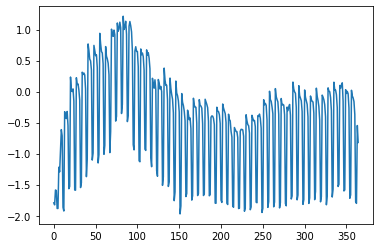

In [ ]:
plt.plot(results)

In [ ]:
results = results * stats.std.value + stats.mean.value

In [ ]:
prediction = pd.DataFrame(results, data_test.index)
prediction = prediction.rename(columns = {0:'value'})

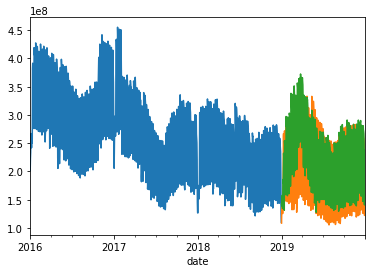

In [ ]:
plt.figure()
data_train['value'].plot(kind = 'line')
data_test['value'].plot(kind = 'line')
#plt.plot(data_forecaste, label = "Prediction")
prediction['value'].plot()
plt.show()

In [ ]:
MAPE(data_test, prediction)

13.700258591545772

In [ ]:
MAPE(data_test, prediction)

13.700258591545772

In [ ]:
prediction = prediction.rename(columns = {"value" :'hits'})
prediction

,hits
date,
2019-01-01,1.415878e+08
2019-01-02,1.390977e+08
2019-01-03,1.575283e+08
2019-01-04,1.567952e+08
2019-01-05,1.346517e+08
...,...
2019-12-27,2.508249e+08
2019-12-28,1.428703e+08
2019-12-29,1.409491e+08


In [ ]:
prediction.to_csv("submission.csv")